In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.deterministic import DeterministicProcess


In [2]:
def count_incidence(df, date, entity):
    if entity == 0:
        ci = len(df.loc[df.FECHA_SINTOMAS == date])
    else:
        ci = len(df.loc[(df.FECHA_SINTOMAS == str(date)) & (df.ENTIDAD_RES == entity)])
    return ci

In [3]:
os.system("wget https://datosabiertos.salud.gob.mx/gobmx/salud/datos_abiertos/datos_abiertos_covid19.zip")
os.system("unzip datos_abiertos_covid19.zip")
os.system("rm datos_abiertos_covid19.zip")

--2022-04-16 07:31:06--  https://datosabiertos.salud.gob.mx/gobmx/salud/datos_abiertos/datos_abiertos_covid19.zip
Resolving datosabiertos.salud.gob.mx (datosabiertos.salud.gob.mx)... 187.210.186.146
Connecting to datosabiertos.salud.gob.mx (datosabiertos.salud.gob.mx)|187.210.186.146|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 304503398 (290M) [application/x-zip-compressed]
Saving to: ‘datos_abiertos_covid19.zip’

     0K .......... .......... .......... .......... ..........  0% 1.48M 3m16s
    50K .......... .......... .......... .......... ..........  0% 11.7M 1m50s
   100K .......... .......... .......... .......... ..........  0% 2.89M 1m47s
   150K .......... .......... .......... .......... ..........  0% 11.3M 87s
   200K .......... .......... .......... .......... ..........  0% 11.5M 74s
   250K .......... .......... .......... .......... ..........  0% 5.61M 71s
   300K .......... .......... .......... .......... ..........  0% 11.5M 64s
   350K

Archive:  datos_abiertos_covid19.zip


In [3]:
file = (pd.to_datetime('today') - pd.Timedelta('1 days')).strftime('%y%m%d')+"COVID19MEXICO.csv" #Database file
Lag = 72 #10 weeks into the past
Date_Range = pd.date_range(end=pd.to_datetime('today').date(), periods=Lag)

In [4]:
df = pd.read_csv(file, engine="python")
columns = list(df.columns)
columns.remove('ENTIDAD_RES')
columns.remove('FECHA_SINTOMAS')
columns.remove('CLASIFICACION_FINAL')
df = df.drop(columns=columns)
df = df.drop(df[pd.to_datetime(df.FECHA_SINTOMAS) < Date_Range[0]].index)
df = df.drop(df[df.CLASIFICACION_FINAL > 3].index)
df = df.drop(columns=['CLASIFICACION_FINAL'])

In [73]:
df_Entities = pd.read_csv("../Data/Entidades.csv")

In [6]:
df_Incidence = pd.DataFrame({'Date':Date_Range})
for entity in range(33):
    Incidence = []
    for date in range(Lag):
        Incidence.append(count_incidence(df, str(Date_Range[date].date()), entity) )
    df_Incidence[df_Entities.iloc[entity, 0]] = Incidence

In [107]:
Entities = list(df_Entities.Entidad)
Incidences = []
Rates = []
trst = 17
for entity in Entities:
    dp = DeterministicProcess(df_Incidence[entity][:Lag-trst].index, constant=False, period=7, fourier=3)
    model_fit = AutoReg(df_Incidence[entity][:Lag-trst], lags=5, trend='n', seasonal=False, deterministic=dp).fit()
    predictions = model_fit.predict(start=Lag-trst, end=Lag-1)
    Incidences.append(sum(predictions[-7:]))
    Rates.append(sum(predictions[-7:])/sum(predictions[-14:-7]) - 1)

df_Entities['Incidencia Semanal'] = Incidences
df_Entities['Incidencia Semanal Normalizada'] = df_Entities['Incidencia Semanal']/df_Entities['Población']*1e5
df_Entities['Tasa de Cambio'] = Rates

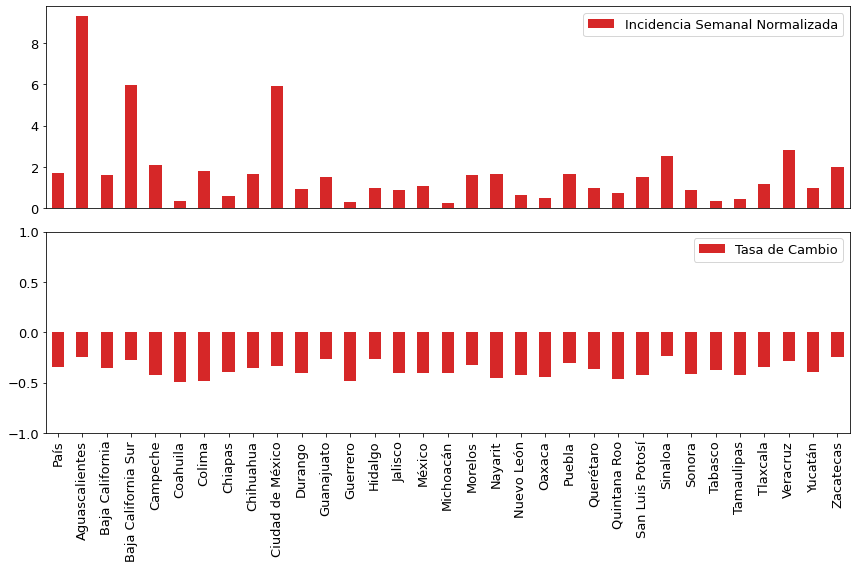

In [111]:
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(12, 8))
df_Entities.plot.bar(x='Entidad', y='Incidencia Semanal Normalizada', color='C3', ax=axs[0])
axs[0].set_xlabel('')
axs[0].set_xticks([])
axs[0].yaxis.set_tick_params(labelsize=13)
axs[0].legend(fontsize=13)
df_Entities.plot.bar(x='Entidad', y='Tasa de Cambio', color='C3', ax=axs[1])
axs[1].set_ylim([-1, 1])
axs[1].set_xlabel('')
axs[1].xaxis.set_tick_params(labelsize=13)
axs[1].yaxis.set_tick_params(labelsize=13)
axs[1].legend(fontsize=13)
fig.tight_layout()
fig.savefig('../docs/Fig01.png')

In [ ]:
os.system("rm "+file)